In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , BatchNormalization , Dropout , Activation ,Input ,Add , UpSampling2D ,Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from sklearn.model_selection import train_test_split

#Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from PIL import Image

mask = np.array(Image.open('/content/drive/MyDrive/images/001_image.png'))

print("Shape:", mask.shape)

if mask.ndim == 3:
    equal = np.all(mask[:, :, 0] == mask[:, :, 1]) and np.all(mask[:, :, 1] == mask[:, :, 2])
    print("All channels equal:", equal)

Shape: (966, 1296, 3)
All channels equal: False


In [ ]:
import numpy as np
import cv2
mask = cv2.imread('/content/001_annotation.png', cv2.IMREAD_UNCHANGED)  # Load without auto-conversion
print(np.unique(mask))

[None]


In [ ]:
import numpy as np
import cv2
import os

def compute_vegetation_indices(img):
    img = img.astype(np.float32) / 255.0
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    exg = 2 * g - r - b
    exr = 1.4 * r - g
    cive = 0.881 * g - 0.441 * r - 0.385 * b - 18.78745
    ndi = (g - r) / (g + r + 1e-10)
    return exg, exr, cive, ndi

def compute_edge_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float32)
    sobel_x = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    laplacian = cv2.Laplacian(gray, cv2.CV_32F)
    canny = cv2.Canny(gray.astype(np.uint8), 100, 200).astype(np.float32) / 255.0
    return sobel_x, sobel_y, laplacian, canny

def preprocess_image(img):
    img = cv2.resize(img, (384, 512))
    img_float = img.astype(np.float32)

    exg, exr, cive, ndi = compute_vegetation_indices(img_float)
    hsv = cv2.cvtColor(img_float / 255.0, cv2.COLOR_RGB2HSV)
    h, s, v = hsv[:, :, 0], hsv[:, :, 1], hsv[:, :, 2]
    sobel_x, sobel_y, laplacian, canny = compute_edge_features(img_float)

    input_volume = np.stack([
        img_float[:, :, 0], img_float[:, :, 1], img_float[:, :, 2],
        exg, exr, cive, ndi,
        h, s, v,
        sobel_x, sobel_y, laplacian, canny
    ], axis=-1)

    input_volume = (input_volume - input_volume.mean(axis=(0, 1), keepdims=True)) / (
        input_volume.std(axis=(0, 1), keepdims=True) + 1e-10)
    return input_volume


# Define your RGB-to-class mapping
CLASS_COLOR_MAP = {
    0: [0, 0, 0],       # Background
    1: [0, 255, 0],     # Crop
    2: [255, 0, 0],     # Weed
}


def rgb_to_class(rgb_mask):
    rgb_mask = cv2.resize(rgb_mask, (384, 512))
    """
    Convert a 3-channel RGB mask to a single-channel class label mask.

    Parameters:
        rgb_mask: numpy array of shape (H, W, 3)

    Returns:
        class_mask: numpy array of shape (H, W, 1)
    """
    h, w, _ = rgb_mask.shape
    class_mask = np.zeros((h, w, 1), dtype=np.uint8)

    for i in range(h):
        for j in range(w):
            pixel = rgb_mask[i, j]
            if np.array_equal(pixel, [0, 0, 0]):
                class_mask[i, j] = 0
            elif np.array_equal(pixel, [0, 255, 0]):
                class_mask[i, j] = 1
            elif np.array_equal(pixel, [0, 0, 255]):
                class_mask[i, j] = 2
            else:
                class_mask[i, j] = 0  # fallback for unexpected colors

    return class_mask

def load_and_preprocess_dataset(image_dir, annotation_dir, mask_dir=None):
    images, labels = [], []
    image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    print(image_files[:5])
    for img_name in image_files:
        img_path = os.path.join(image_dir, img_name)
        # print(img_path)
        base_name = os.path.splitext(img_name)[0]
        # print(base_name)
        base_id = base_name.split('_')[0]
        # print(base_id)  # Output: '001'
        mask_name = f"{base_id}_mask.png"
        ann_name = f"{base_id}_annotation.png"

        # print(ann_name)
        mask_path = os.path.join(mask_dir, mask_name)
        ann_path = os.path.join(annotation_dir, ann_name)
        print(ann_path)

        if not os.path.exists(mask_path):
            print(f"Annotation missing for: {mask_name}")
            continue



        img = cv2.imread(img_path)

        label = cv2.imread(ann_path)
        # mask = cv2.imread(mask_path)
        ann_image = cv2.imread(ann_path)
        # print(ann.shape)
        # print(ann_image)
        # print(label)

        if img is None or label is None:
            print(f"Skipping {img_name} due to loading error.")
            continue
        # images.append(img)
        # labels.append(label)

        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        try:
            img_processed = preprocess_image(img)

            label_processed = rgb_to_class(label)
            # print(label_processed.shape)
            images.append(img_processed)
            labels.append(label_processed)
            for i in range(3):
              print(label_processed[10][i])
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
            continue

    if not images:
        raise ValueError("No valid data processed.")

    X = np.stack(images)
    y = np.stack(labels)

    print(f"Final dataset shape: {X.shape} (X), {y.shape} (y)")
    return X, y

In [ ]:
def load_input_dataset(image_dir): #function to load image from google drive
  images = []
  image_names = sorted([f for f in os.listdir(image_dir) if f.lower().endswith('png')])
  print(image_names[:5])

In [ ]:
images = load_input_dataset("/content/drive/My Drive/images") # laoding images from google drive


['001_image.png', '002_image.png', '003_image.png', '004_image.png', '005_image.png']


In [ ]:
# Load and preprocess dataset
images, labels = load_and_preprocess_dataset(
    image_dir="/content/drive/My Drive/images",
     annotation_dir="/content/drive/My Drive/annotations",
    mask_dir="/content/drive/My Drive/masks"
)
# print(images)

# Save first pair for inspection

X_temp, X_test, y_temp, y_test = train_test_split(
    images, labels, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42  # 0.15/0.85
)
print(f"Split: {len(X_train)} train, {len(X_val)} val, {len(X_test)} test")

['001_image.png', '002_image.png', '003_image.png', '004_image.png', '005_image.png']
/content/drive/My Drive/annotations/001_annotation.png
[0]
[0]
[0]
/content/drive/My Drive/annotations/002_annotation.png
[0]
[0]
[0]
/content/drive/My Drive/annotations/003_annotation.png
[0]
[0]
[0]
/content/drive/My Drive/annotations/004_annotation.png
[0]
[0]
[0]
/content/drive/My Drive/annotations/005_annotation.png
[0]
[0]
[0]
/content/drive/My Drive/annotations/006_annotation.png
[0]
[0]
[0]
/content/drive/My Drive/annotations/007_annotation.png
[0]
[0]
[0]
/content/drive/My Drive/annotations/008_annotation.png
[0]
[0]
[0]
/content/drive/My Drive/annotations/009_annotation.png
[0]
[0]
[0]
/content/drive/My Drive/annotations/010_annotation.png
[0]
[0]
[0]
/content/drive/My Drive/annotations/011_annotation.png
[0]
[0]
[0]
/content/drive/My Drive/annotations/012_annotation.png
[0]
[0]
[0]
/content/drive/My Drive/annotations/013_annotation.png
[0]
[0]
[0]
/content/drive/My Drive/annotations/014_ann

#architecture

In [ ]:

# Input
input_tensor = Input(shape=(512, 384, 14))

# Initial Conv + BN + ReLU
x = Conv2D(16, kernel_size=(5,5), padding="same")(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

In [ ]:
class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=2, padding='VALID', **kwargs):
        super().__init__(**kwargs)
        self.pool_size = [1, *pool_size, 1]
        self.strides = [1, strides, strides, 1]
        self.padding = padding

    def call(self, inputs):
        pooled, argmax = tf.nn.max_pool_with_argmax(
            inputs,
            ksize=self.pool_size,
            strides=self.strides,
            padding=self.padding,
            # output_dtype=tf.int32  # Use tf.int32 for compatibility
        )
        return [pooled, argmax]


In [ ]:
argmax_list = []
for i in range(12):
    res = Conv2D(8 , kernel_size=(1,1), padding='same')(x)
    res = Activation('relu')(res)
    res = Conv2D(8 , kernel_size=(5,1), padding='same')(res)
    res = Activation('relu')(res)
    res = Conv2D(8 , kernel_size=(1,5), padding='same')(res)
    res = Activation('relu')(res)
    res = Conv2D(16, kernel_size=(1,1), padding='same')(res)
    res = Activation('relu')(res)

    x = Add()([x, res])

    if (i + 1) % 3 == 0:
        x, argmax = MaxPoolingWithArgmax2D()(x)
        argmax_list.append(argmax)


#custom unpooling layer

In [ ]:
class MaxUnpooling2D(Layer):
    def __init__(self, pool_size=(2, 2)):
        super(MaxUnpooling2D, self).__init__()
        self.pool_size = pool_size

    def call(self, inputs, argmax, output_shape=None):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]

        out_height = height * self.pool_size[0]
        out_width = width * self.pool_size[1]

        out_height += tf.cast(tf.math.floormod(height, 2), tf.int32)
        out_width += tf.cast(tf.math.floormod(width, 2), tf.int32)

        output_shape = tf.stack([batch_size, out_height, out_width, channels])

        flat_input = tf.reshape(inputs, [-1])
        flat_argmax = tf.cast(tf.reshape(argmax, [-1]), tf.int32)  # Cast here

        output = tf.scatter_nd(
            indices=tf.expand_dims(flat_argmax, 1),
            updates=flat_input,
            shape=[tf.reduce_prod(output_shape)]
        )

        return tf.reshape(output, output_shape)

#Decoder

In [ ]:
j = len(argmax_list)
for i in range(12):

    if((i+1)% 3 == 1):
      unpool = MaxUnpooling2D()
      x = unpool(x, argmax_list[j-1])
      j -= 1

    res = Conv2D(8 , kernel_size=(1,1), padding='same')(x)
    res = Activation('relu')(res)
    res = Conv2D(8 , kernel_size=(5,1), padding='same')(res)
    res = Activation('relu')(res)
    res = Conv2D(8 , kernel_size=(1,5), padding='same')(res)
    res = Activation('relu')(res)
    res = Conv2D(16, kernel_size=(1,1), padding='same')(res)
    res = Activation('relu')(res)

    # Residual connection
    x = Add()([x, res])


In [ ]:
x = Conv2D(3, kernel_size=(1, 1), padding='same')(x)
x = Activation('softmax')(x)

In [ ]:

# Final model
model = Model(inputs=input_tensor, outputs=x)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 384,  │          0 │ -                 │
│ (InputLayer)        │ 14)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 512, 384,  │      5,616 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 384,  │         64 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 512, 384,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 512, 384,  │        136 │ activation_98[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_99       │ (None, 512, 384,  │          0 │ conv2d_99[0][0]   │
│ (Activation)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 512, 384,  │        328 │ activation_99[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_100      │ (None, 512, 384,  │          0 │ conv2d_100[0][0]  │
│ (Activation)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (Conv2D) │ (None, 512, 384,  │        328 │ activation_100[0… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_101      │ (None, 512, 384,  │          0 │ conv2d_101[0][0]  │
│ (Activation)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_102 (Conv2D) │ (None, 512, 384,  │        144 │ activation_101[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_102      │ (None, 512, 384,  │          0 │ conv2d_102[0][0]  │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 512, 384,  │          0 │ activation_98[0]… │
│                     │ 16)               │            │ activation_102[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_103 (Conv2D) │ (None, 512, 384,  │        136 │ add_24[0][0]      │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_103      │ (None, 512, 384,  │          0 │ conv2d_103[0][0]  │
│ (Activation)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_104 (Conv2D) │ (None, 512, 384,  │        328 │ activation_103[0… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_104      │ (None, 512, 384,  │          0 │ conv2d_104[0][0]

 Total params: 28,195 (110.14 KB)

 Trainable params: 28,163 (110.01 KB)

 Non-trainable params: 32 (128.00 B)

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# 1. Split the data using sklearn
X_temp, X_test, y_temp, y_test = train_test_split(
    images, labels, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42
)




# 3. Convert NumPy arrays to tf.data.Dataset and apply preprocessing
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# 4. Apply resizing using .map()
# Define a proper preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # normalize to [0, 1]
    return image, label

# Now map it to each dataset before batching
train_ds = train_ds.batch(5).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(5).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(5).prefetch(tf.data.AUTOTUNE)


In [ ]:
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy'
 , metrics=['accuracy'])



In [ ]:
history = model.fit(
    train_ds,
    epochs=5,
    batch_size=10,
    validation_data=val_ds
)


Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 126s 9s/step - accuracy: 0.8341 - loss: 1.1929 - val_accuracy: 0.9008 - val_loss: 1.0103
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 126s 8s/step - accuracy: 0.9009 - loss: 0.9505 - val_accuracy: 0.9287 - val_loss: 0.8753
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.9197 - loss: 0.8169 - val_accuracy: 0.9350 - val_loss: 0.7762
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 72s 8s/step - accuracy: 0.9232 - loss: 0.6983 - val_accuracy: 0.9362 - val_loss: 0.6339
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.9235 - loss: 0.5443 - val_accuracy: 0.9364 - val_loss: 0.4439


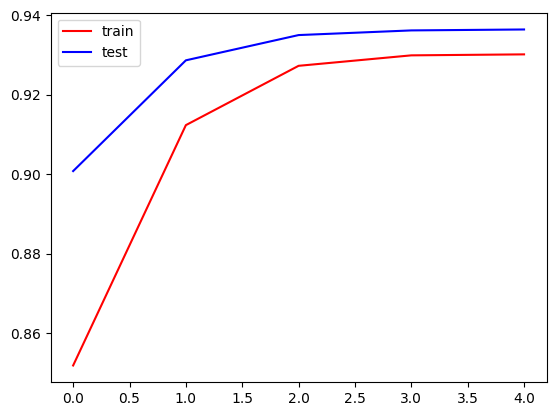

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'] , color='red' , label="train")
plt.plot(history.history['val_accuracy'] , color='blue' , label="test")
plt.legend()
plt.show()

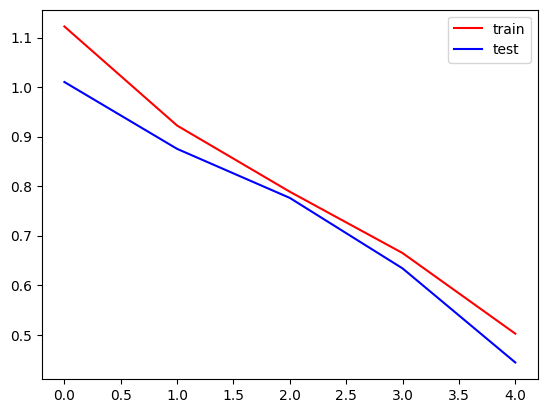

In [ ]:
plt.plot(history.history['loss'] , color='red' , label='train')
plt.plot(history.history['val_loss'] , color='blue' , label='test')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the color map (0: black, 1: red, 2: green, etc.)
def color_map(mask):
    mask = np.squeeze(mask)  # In case mask is (H, W, 1)
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    print(mask)
    color_mask[mask == 0] = [0, 0, 0]       # black
    color_mask[mask == 1] = [0, 0, 255]     # red
    color_mask[mask == 2] = [255, 0, 0]     # green

    return color_mask

# Visualize one prediction vs ground truth
def visualize_prediction(image, true_mask, prediction_probs, num_classes=3):

    pred_class = np.argmax(prediction_probs, axis=-1)  # (H, W)
    print("True mask unique values:", np.unique(true_mask))
    print("Predicted mask unique values:", np.unique(pred_class))
    # print(prediction_probs)
    # Convert masks to RGB
    true_colored = color_map(true_mask)        # no argmax here
    pred_colored = color_map(pred_class)


    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    rgb_image = image[:, :, :3]  # Take first 3 channels
    plt.imshow(rgb_image)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(true_colored)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(pred_colored)
    plt.axis('off')
    # print(pred_colored)

    plt.tight_layout()
    plt.show()

In [ ]:
# Take one batch from test_ds
for images, labels in test_ds.take(1):
    print(images.shape)
    print(labels.shape)
    # Make predictions
    predictions = model.predict(images)

    # Show the first image
    visualize_prediction(
        image=images[0].numpy(),
        true_mask=labels[0].numpy(),
        prediction_probs=predictions[0],
        num_classes=3
    )
    break

(5, 512, 384, 14)
(5, 512, 384, 1)
